In [7]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
#import triangle
from IPython.display import display, Math, Latex
%matplotlib inline
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
#from __future__ import print_function
import pymc
from pymc import AdaptiveMetropolis 
import random




In [8]:
import ezgal
import emcee

In [9]:
ID, G_50, R_50, I_50, Gerr, Rerr, Ierr, R4, redshift=np.loadtxt('SDSS_C4_50kpc_ADD_Feb28_all.txt',unpack=True)
# This is just the SDSS ID number, g-,r-,i-band photometry, then the g-,r-,i-band uncertainty, then the 4th brightest (not needed) and the photometric redshift

In [10]:
import astropy.cosmology
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo=FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc, Om0=0.3)

distance_C4_pc_M14=(cosmo.luminosity_distance(redshift).value)*10**6

absolute_R_50 = R_50- 5.*np.log10(distance_C4_pc_M14/10.)

#This is just an exmaple for the estimate of the R-band absolute magnitude, which i use as the normalization parameter

In [11]:
import ezgal

met = [0.008]

formation = 4.9

model=ezgal.ezgal('bc03_ssp_z_0.008_salp.model')
model.set_cosmology(Om=0.3, Ol=0.7, h=0.7, w=-1)
model.add_filter('sloan_g')
model.add_filter('sloan_r')
model.add_filter('sloan_i')
zf=formation


# These are the parameter estimates for cosmology, the sps model, the metallicity, the imf
# They can all be changed


In [12]:
array=np.zeros([len(redshift),8])
for i in range(len(redshift)):
    array[i,0]=redshift[i]
    array[i,1]=G_50[i]
    array[i,2]=R_50[i]
    array[i,3]=I_50[i]
    array[i,4]=Gerr[i]
    array[i,5]=Rerr[i]
    array[i,6]=Ierr[i]
    array[i,7]=absolute_R_50[i]


# This is the array that I feed into the MCMC model that I use.  You need redshift, magnitudes, uncertainty, and the estimate for the normalization    

In [13]:
print len(redshift)
Absolute_Ezgal_R_Salp=np.zeros(len(redshift))
Uncertainty_Salp=np.zeros(len(redshift))

# This is the output


285


In [14]:
from multiprocessing import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

from multiprocessing import Pool

# THis is so it can run on multiple cores

8 CPUs


In [15]:
print i

284


0


ezgal/cosmology.py:149: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)
ezgal/cosmology.py:149: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)
ezgal/cosmology.py:149: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)
ezgal/cosmology.py:149: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)
ezgal/cosmology.py:149: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)
ezgal/cosmology.py:149: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)
ezgal/cosmology.py:149: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


CPU times: user 5.54 s, sys: 545 ms, total: 6.09 s
Wall time: 17 s
done
-23.06329605442859


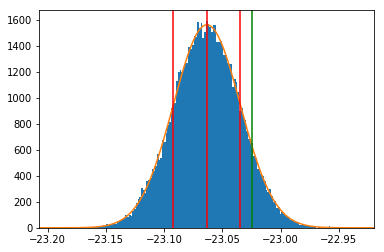

In [16]:
for i in range(0,1):
    print i
    # This is the priors that I use for each of the search parameters for the Absolute magnitude (1.5 can be expanded)
    def log_prior(theta,zs,Gobs,Robs,Iobs,Gerr,Rerr,Ierr,Rabs):
        alpha = theta[0]
        if alpha < Rabs-1.5:
            return -np.inf  # log(0)
        if alpha > Rabs+1.5:
            return -np.inf
        else:
            return 0.0
    

    def log_likelihood(theta,zs,Gobs,Robs,Iobs,Gerr,Rerr,Ierr,Rabs):
        alpha=theta[0]
        model.set_normalization('sloan_r',zs,alpha)
        Gezgal,Rezgal,Iezgal=(zs,model.get_apparent_mags(zf=formation,filters=['des_g','des_r','des_i'],zs=zs))[1][0]

        return -1.0*(((Gobs-Gezgal)/Gerr)**2 + ((Robs-Rezgal)/Rerr)**2 + ((Iobs-Iezgal)/Ierr)**2)
    
    # The log-likelihood does the chi-squared minimization to determine which absolute magnitude gives the best fit
    # when you're runnign the model, you can add things to it like dust extinction and k-correction
    def log_posterior(theta,zs,Gobs,Robs,Iobs,Gerr,Rerr,Ierr,Rabs):
        return log_prior(theta,zs,Gobs,Robs,Iobs,Gerr,Rerr,Ierr,Rabs) + log_likelihood(theta,zs,Gobs,Robs,Iobs,Gerr,Rerr,Ierr,Rabs)

    ndim = 1  # number of parameters in the model
    nwalkers = 50  # number of MCMC walkers
    nburn = 500  # "burn-in" period to let chains stabilize
    nsteps = 1500  # number of MCMC steps to take

    # set theta near the maximum likelihood, with 
    np.random.seed(0)
    starting_guesses = np.random.uniform(absolute_R_50[i]-10.*Rerr[i],absolute_R_50[i]+10.*Rerr[i],(50,1))

    pool = Pool(processes=7)
    # I usually set processes to 1 less than the max so my computer doesn't overload
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=array[i],pool=pool)
    %time sampler.run_mcmc(starting_guesses, nsteps)
    print("done")
    pool.close()
    from scipy.optimize import curve_fit
    n,bins,patches=plt.hist(sampler.flatchain,bins=np.linspace(np.median(sampler.flatchain)-20.*Rerr[i],np.median(sampler.flatchain)+20.*Rerr[i],2000))
#    n,bins,patches=plt.hist(sampler.flatchain,bins=1000)
    
    bins2=[]
    for j in range(0,len(bins)-1):
        bins2.append((bins[j]+bins[j+1])/2.)
    bins2=np.array(bins2)

    def gauss_function(x, a, x0, sigma):
        return a*np.exp(-(x-x0)**2./(2.*sigma**2.))
    popt, pcov = curve_fit(gauss_function, bins2, n, p0 = [1, np.median(sampler.flatchain), np.sqrt(np.var(sampler.flatchain))])
    plt.plot(bins2, gauss_function(bins2, *popt), label='fit')

    plt.axvline(popt[1],color='red')
    plt.axvline(popt[1]+popt[2],color='red')
    plt.axvline(popt[1]-popt[2],color='red')
    plt.xlim(popt[1]-5.*popt[2],popt[1]+5.*popt[2])
    print popt[1]
    
    plt.axvline(absolute_R_50[i],color='green')
    plt.show()
    
    # This is just an example plot (not necessary) to see how the fitting does
    Absolute_Ezgal_R_Salp[i]=popt[1]
    Uncertainty_Salp[i]=popt[2]



In [21]:
f=open('All_C4_ID_LumEzgal_Uncertainty_Salp_point008_all_ADD50_Feb28.txt','w')
for i in range(len(Uncertainty_Salp)):
    if Absolute_Ezgal_R_Salp[i] != 0.0:
        f.write(str(ID[i])+" "+str(Absolute_Ezgal_R_Salp[i])+" "+str(np.abs(Uncertainty_Salp[i]))+"\n")

In [126]:
ID, Absolute_Ezgal_R_Salp, Uncertainty_Salp = np.loadtxt('All_C4_ID_LumEzgal_Uncertainty_Salp_point008_all_ADD50_Feb28.txt',unpack=True)

In [127]:
import ezgal


met = [0.008]

formation = 4.9

model=ezgal.ezgal('bc03_ssp_z_0.008_salp.model')
model.set_cosmology(Om=0.3, Ol=0.7, h=0.7, w=-1)
model.add_filter('sloan_g')
model.add_filter('sloan_r')
model.add_filter('sloan_i')
zf=formation


Mass_salp=np.zeros(len(redshift))
Mass_salp_upper=np.zeros(len(redshift))
Mass_salp_lower=np.zeros(len(redshift))

Gezgal=np.zeros(len(redshift))
Rezgal=np.zeros(len(redshift))
Iezgal=np.zeros(len(redshift))
Chi_squared_salp=np.zeros(len(redshift))


for j in range(len(redshift)):
    zs=redshift[j]
    model.set_normalization('sloan_r',redshift[j],Absolute_Ezgal_R_Salp[j],apparent=False)    
    Mass=model.get_masses(formation,redshift[j])*(model.get_normalization(formation,flux=True))
    Mass_salp[j] = np.log10(Mass[0][0])
    Gezgal=(zs,model.get_apparent_mags(zf=formation,filters='sloan_g',zs=zs))[1]
    Rezgal=(zs,model.get_apparent_mags(zf=formation,filters='sloan_r',zs=zs))[1]
    Iezgal=(zs,model.get_apparent_mags(zf=formation,filters='sloan_i',zs=zs))[1]
    Chi_squared_salp[j]=(((G_50[j]-Gezgal)/Gerr[j])**2 + ((R_50[j]-Rezgal)/Rerr[j])**2 + ((I_50[j]-Iezgal)/Ierr[j])**2)
    
    
# In this code, I use the same Ezgal model and then set the absolute magnitude that best fit from the chi-squared as the normalization
# Then I get the Stellar mass as the output (as well as the chi_squared so I can remove outliers)
# The chi-squared is usually gaussian like.  I usually throw out everything worse than 1 sigma from the median chi-squared




